In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats
import pandas as pd
%matplotlib inline
plt.rcParams["figure.dpi"] = 150
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
OUTPUT_PATH = os.path.join(BASE_PATH, 'analysis', 'img')

In [9]:
# Adapted from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(font='Helvetica',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': True,
 'axes.axisbelow': True,
 'grid.color': 'lightgrey',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":16,
                                "axes.labelsize":13})

In [8]:
def parse_json(path):
    data = {}
    for f in os.listdir(path):
        lambda_no = 1
        has_multiple_lambda = False
        matches_multiple_lambda = re.search(r"(producer|consumer)_(\d+)_(\d+)_(\d+).json", f)
        if matches_multiple_lambda:
            lambda_no = int(matches_multiple_lambda.group(4))
            has_multiple_lambda = True
            matches = matches_multiple_lambda
        else:
            matches = re.search(r"(producer|consumer)_(\d+)_(\d+).json", f)
        if matches:
            run_type, file_size, run = matches.group(1), int(matches.group(2)), int(matches.group(3))
            if run_type not in data:
                data[run_type] = {}
            if file_size not in data[run_type]:
                data[run_type][file_size] = {}
            if has_multiple_lambda and run not in data[run_type][file_size]:
                data[run_type][file_size][run] = {}
            with open(os.path.join(path, f)) as file_p:
                json_data = json.load(file_p)
                if has_multiple_lambda:
                    data[run_type][file_size][run][lambda_no] = json_data
                else:
                    data[run_type][file_size][run] = json_data
    return data

In [4]:
def calc_deltas(data):
    deltas = {}
    for file_size, runs in data['consumer'].items():
        deltas[file_size] = {}
        for run_number, run_data in runs.items():
            if 'finishedTime' in run_data: # single lambda
                if int(np.log10(run_data['finishedTime'])) == 15:
                    # Convert to ms
                    run_data['finishedTime'] /= 1000
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                if run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime'] < 0.1:
                    deltas[file_size][run_number] = 0.1
                else:
                    deltas[file_size][run_number] = run_data['finishedTime'] - data['producer'][file_size][run_number]['uploadTime']
                
            else:
                all_finished_times = [lambda_run['finishedTime'] for lambda_run in run_data.values()]
                if int(np.log10(data['producer'][file_size][run_number]['uploadTime'])) == 15:
                    data['producer'][file_size][run_number]['uploadTime'] /= 1000
                    all_finished_times = [v / 1000 for v in all_finished_times]
                all_deltas = []
                for fin_time in all_finished_times:
                    if fin_time - data['producer'][file_size][run_number]['uploadTime'] < 0:
                        all_deltas.append(0.1)
                    else:
                        all_deltas.append(fin_time - data['producer'][file_size][run_number]['uploadTime'])

                deltas[file_size][run_number] = all_deltas
    return deltas

In [7]:
def format_xticks(label_values):
    xticks = []
    for val in label_values:
        if val == 10000:
            xticks.append("10⁴")
        elif val == 100000:
            xticks.append("10⁵")
        elif val == 500000:
            xticks.append("5·10⁵")
        elif val >= 1:
            xticks.append(str(int(val)))
        else:
            xticks.append(str(val))
    return xticks

# Peer-To-Peer

In [5]:
experiments = {
    "S3": os.path.join(BASE_PATH, "s3"),
    "Redis": os.path.join(BASE_PATH, "redis"),
    "DynamoDB": os.path.join(BASE_PATH, "nat"),
    "TCP": os.path.join(BASE_PATH, "nat"),
}


ShapiroResult(statistic=0.24865847826004028, pvalue=2.674668962085895e-20)
S3
222.2
ShapiroResult(statistic=0.9526926875114441, pvalue=0.0012534911511465907)
Redis
13.5
ShapiroResult(statistic=0.9268631339073181, pvalue=3.318036760902032e-05)
DynamoDB
10.0


<ipython-input-10-2c4fa45fc1e0>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


ShapiroResult(statistic=0.9268631339073181, pvalue=3.318036760902032e-05)
TCP
10.0


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


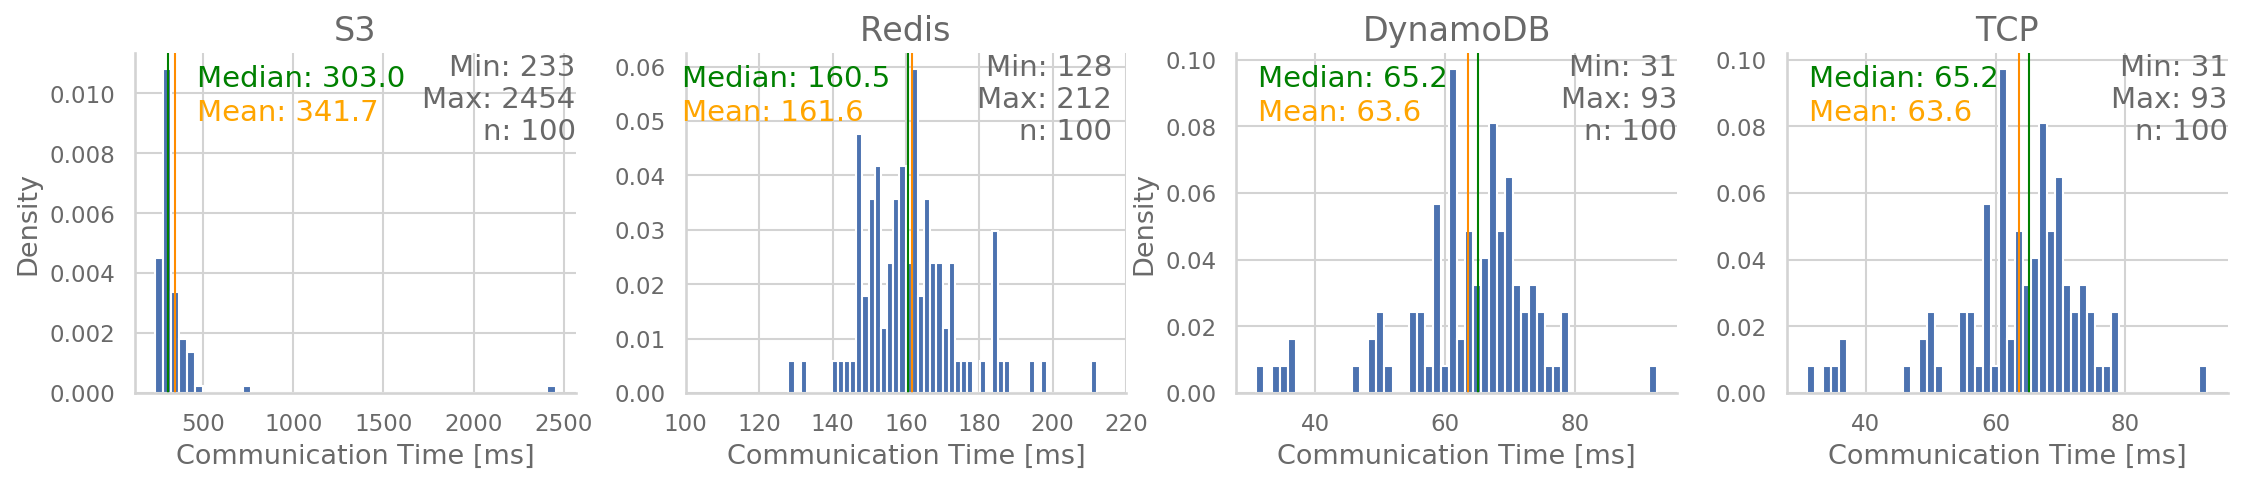

In [10]:
fig = plt.figure(figsize=(18,3))
gs = matplotlib.gridspec.GridSpec(1, 4, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
axes.append(fig.add_subplot(gs[0, 3]))
i = 0
exp_analysis = experiments.copy()
for experiment_name, exp_base_path in exp_analysis.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = list(deltas[10000000].values())
    print(scipy.stats.shapiro(delta_vals))
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    std = np.std(delta_vals)
    print(experiment_name)
    print(round(std, 1))
    median = np.median(delta_vals)
    ax.hist(delta_vals, density=True, bins=50)
    ax.set_xlabel("Communication Time [ms]")
    if i == 0 or i ==2:
        ax.set_ylabel("Density")
    ax.axvline(mean, color='darkorange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    y_offset_1 = 0.9
    y_offset_2 = 0.8
    if experiment_name == "TCP":
        offset = - (max_xlim - min_xlim) / 2
    if experiment_name == "DynamoDB":
        offset = - (max_xlim - min_xlim) / 2
    elif experiment_name == "Redis":
        ax.set_xlim([100, 220])
        offset = -(max_xlim - min_xlim) / 1.5
    ax.text(median + offset, max_ylim*y_offset_1, 'Median: {:.1f}'.format(median), color="green", size="medium")
    ax.text(median + offset, max_ylim*y_offset_2, 'Mean: {:.1f}'.format(mean), color="orange", size="medium")
    ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='medium', horizontalalignment='right', verticalalignment='top')
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance_10MB.pdf"), bbox_inches='tight')

# P2P Benchmark Violin

           val type
0   282.000000   S3
1   356.000000   S3
2   312.000000   S3
3   288.000000   S3
4   324.000000   S3
..         ...  ...
95   72.968018  TCP
96   61.720947  TCP
97   70.397949  TCP
98   74.137939  TCP
99   64.495117  TCP

[400 rows x 2 columns]


<ipython-input-26-23e76bab2002>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


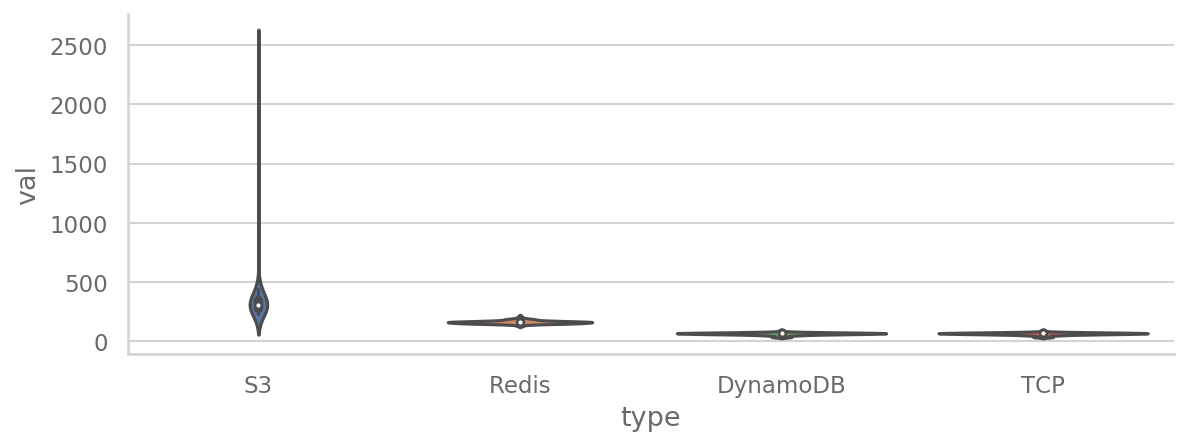

In [26]:
fig = plt.figure(figsize=(9,3))
i = 0
exp_analysis = experiments.copy()

data = []

for experiment_name, exp_base_path in exp_analysis.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = list(deltas[10000000].values())
    df = pd.DataFrame(data=delta_vals,columns=['val'])
    df['type'] = experiment_name
    #print(df)
    data.append(df)
    #print(scipy.stats.shapiro(delta_vals))
    #mean = np.mean(delta_vals)
    #var = np.var(delta_vals)
    #std = np.std(delta_vals)
    #print(experiment_name)
    #print(round(std, 1))
    #median = np.median(delta_vals)
    #print(median)

df = pd.concat(data)
print(df)
    
sns.violinplot(data=df, x='type',y='val')
    
fig.show()

          val type
0   36.000000   S3
1   35.000000   S3
2   42.000000   S3
3   66.000000   S3
4   38.000000   S3
..        ...  ...
95   0.100000  TCP
96   0.100000  TCP
97   0.629883  TCP
98   1.742188  TCP
99   1.083984  TCP

[400 rows x 2 columns]


<ipython-input-42-4d142494fd3e>:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


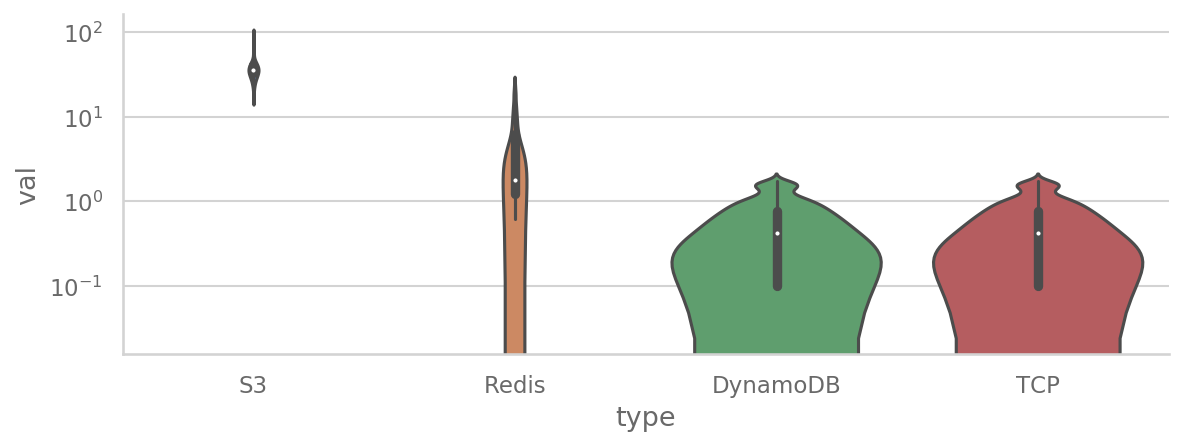

In [42]:
fig = plt.figure(figsize=(9,3))
i = 0
exp_analysis = experiments.copy()

data = []

for experiment_name, exp_base_path in exp_analysis.items():
    #if experiment_name == 'S3' or experiment_name == 'Redis':
    #    continue
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution_1b", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = list(deltas[1].values())
    df = pd.DataFrame(data=delta_vals,columns=['val'])
    df['type'] = experiment_name
    #print(df)
    data.append(df)
    #print(scipy.stats.shapiro(delta_vals))
    #mean = np.mean(delta_vals)
    #var = np.var(delta_vals)
    #std = np.std(delta_vals)
    #print(experiment_name)
    #print(round(std, 1))
    #median = np.median(delta_vals)
    #print(median)

df = pd.concat(data)
print(df)
    
ax = sns.violinplot(data=df, x='type',y='val')
ax.set_yscale('log',basey=10)    
fig.show()

ShapiroResult(statistic=0.747512936592102, pvalue=8.051530796249207e-12)
S3
12.5
ShapiroResult(statistic=0.7140586972236633, pvalue=1.1611606858322188e-12)
Redis
5.7
ShapiroResult(statistic=0.850959300994873, pvalue=1.2869171506224575e-08)
DynamoDB
0.5
ShapiroResult(statistic=0.850959300994873, pvalue=1.2869171506224575e-08)
TCP
0.5


<ipython-input-55-71c6f08af1f0>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


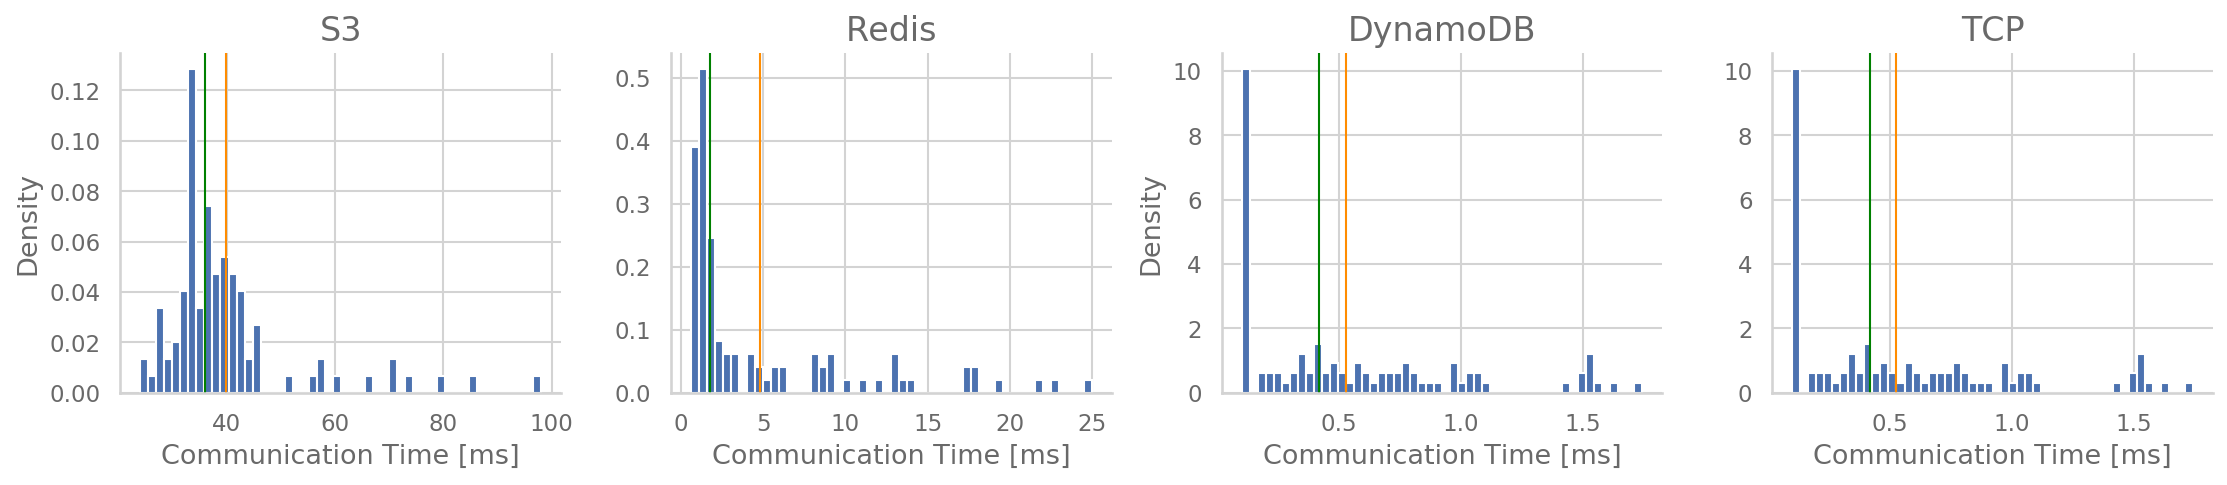

In [55]:
fig = plt.figure(figsize=(18,3))
gs = matplotlib.gridspec.GridSpec(1, 4, wspace=0.25, hspace=0.5) # 2x2 grid
axes = []
axes.append(fig.add_subplot(gs[0, 0]))
axes.append(fig.add_subplot(gs[0, 1]))
axes.append(fig.add_subplot(gs[0, 2]))
axes.append(fig.add_subplot(gs[0, 3]))
i = 0
exp_analysis = experiments.copy()
for experiment_name, exp_base_path in exp_analysis.items():
    ax = axes[i]
    ax.set_title(experiment_name)
    var_base_path = os.path.join(exp_base_path, "p2p", "latency_distribution_1b", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    delta_vals = [x * 1 for x in list(deltas[1].values())]
    print(scipy.stats.shapiro(delta_vals))
    mean = np.mean(delta_vals)
    var = np.var(delta_vals)
    std = np.std(delta_vals)
    print(experiment_name)
    print(round(std, 1))
    median = np.median(delta_vals)
    ax.hist(delta_vals, density=True, bins=50)
    ax.set_xlabel("Communication Time [ms]")
    if i == 0 or i ==2:
        ax.set_ylabel("Density")
    ax.axvline(mean, color='darkorange', linewidth=1)
    ax.axvline(median, color='green', linewidth=1)
    min_ylim, max_ylim = ax.get_ylim()
    min_xlim, max_xlim = ax.get_xlim()
    offset = (max_xlim - min_xlim) / 15
    y_offset_1 = 0.9
    y_offset_2 = 0.8
    if experiment_name == "TCP":
        offset = - (max_xlim - min_xlim) / 2
    if experiment_name == "DynamoDB":
        offset = - (max_xlim - min_xlim) / 2
    elif experiment_name == "Redis":
        #ax.set_xlim([100, 220])
        offset = -(max_xlim - min_xlim) / 1.5
    #ax.text(median + offset, max_ylim*y_offset_1, 'Median: {:.1f}'.format(median), color="green", size="medium")
    #ax.text(median + offset, max_ylim*y_offset_2, 'Mean: {:.1f}'.format(mean), color="orange", size="medium")
    #ax.text(max_xlim, max_ylim, 'Min: {:.0f}\nMax: {:.0f}\nn: {}'.format(np.min(delta_vals), np.max(delta_vals), len(delta_vals)), size='medium', horizontalalignment='right', verticalalignment='top')
    i += 1
fig.show()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_variance_1b.pdf"), bbox_inches='tight')

{0.001: 2.666666666666667e-05, 1.0: 0.02127659574468085, 10.0: 0.2564102564102564, 100.0: 2.197802197802198, 1000.0: 9.174311926605503, 10000.0: 37.17472118959108, 100000.0: 53.951982735365526}
{0.001: 0.0005, 1.0: 0.6666666666666666, 10.0: 4.0, 100.0: 8.333333333333334, 1000.0: 19.801980198019802, 10000.0: 52.35602094240838, 100000.0: 96.15384615384616}
{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846}
{0.001: 0.0024541641701617736, 1.0: 10.0, 10.0: 31.905281196448048, 100.0: 63.17088217149908, 1000.0: 136.29481740287832, 10000.0: 171.67525881218828, 100000.0: 467.46544367846}


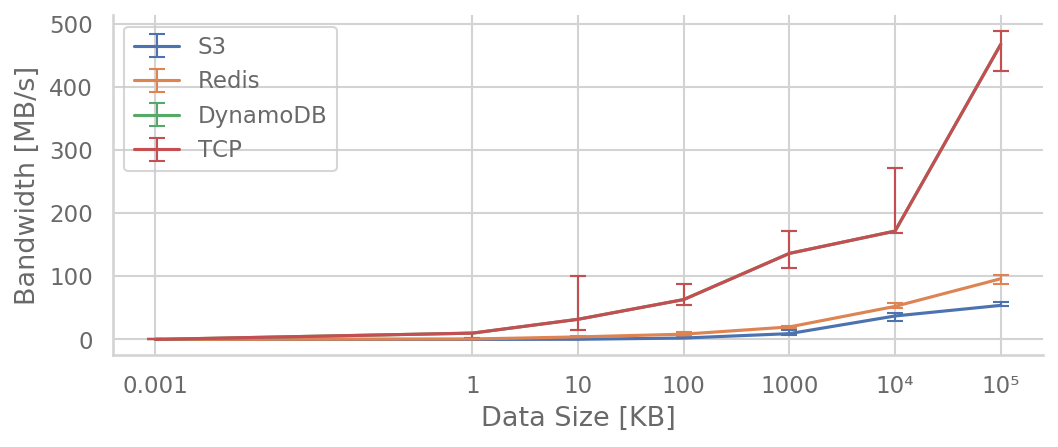

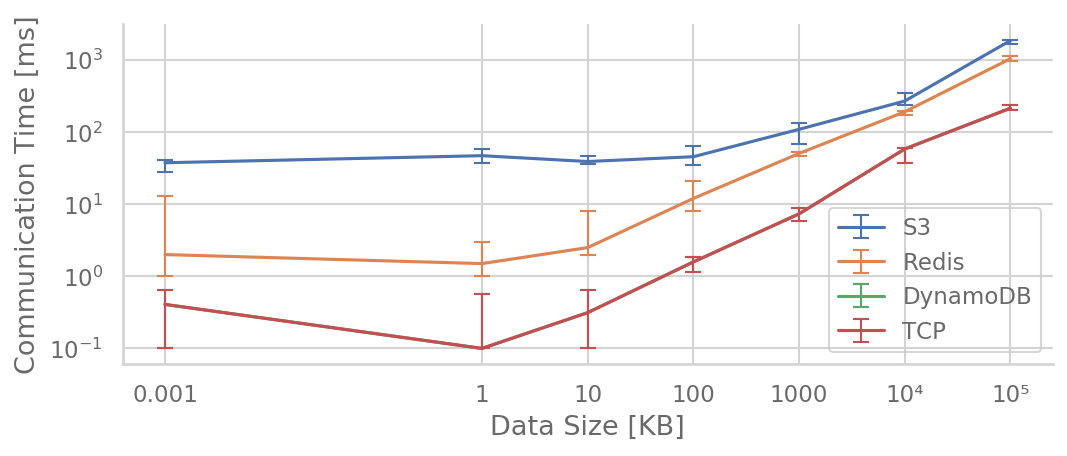

In [64]:
p2p_experiment_means = {}
p2p_experiment_cis = {}
fig, fig2 = plt.figure(figsize=(8,3)), plt.figure(figsize=(8,3))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
exp_analysis = experiments.copy()
for experiment_name, exp_base_path in exp_analysis.items():
    p2p_experiment_means[experiment_name] = {}
    p2p_experiment_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "p2p", "scaling", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = file_size / np.median(values) / 1000
        mean = np.mean(values)
        ci = scipy.stats.sem(values) * scipy.stats.t.ppf((1 + 0.95) / 2., len(values) - 1)
        p2p_experiment_means[experiment_name][file_size / 1000] = mean
        p2p_experiment_cis[experiment_name][file_size / 1000] = ci
        plot_data[file_size / 1000] = val
        upper_ci = file_size / np.sort(values)[1] / 1000 - val
        lower_ci = val - file_size / np.sort(values)[-2] / 1000
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        val = np.median(values)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(values)[-2] - val
        lower_ci = val - np.sort(values)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)



ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "p2p_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "p2p_latency.pdf"), bbox_inches='tight')
plt.show()


# Broadcast (One-To-Many)

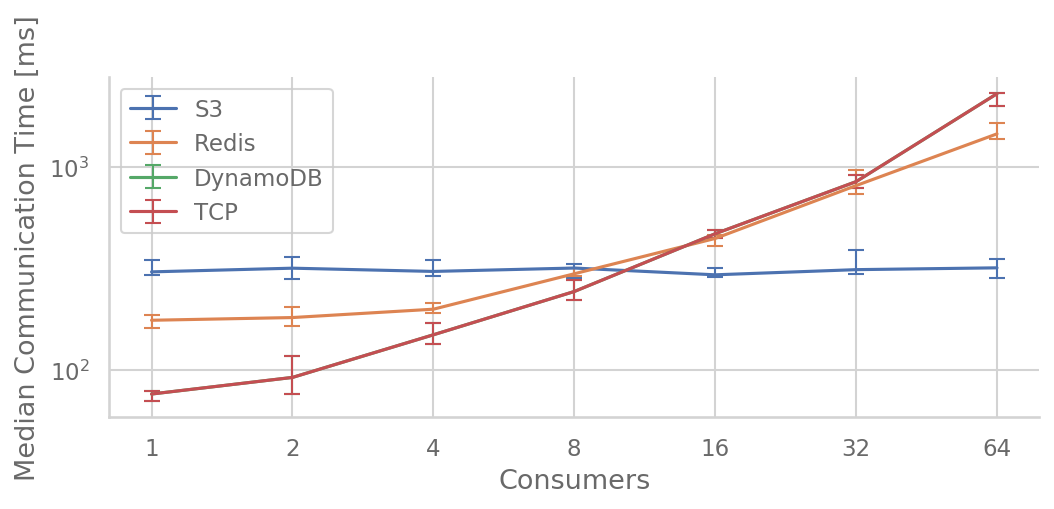

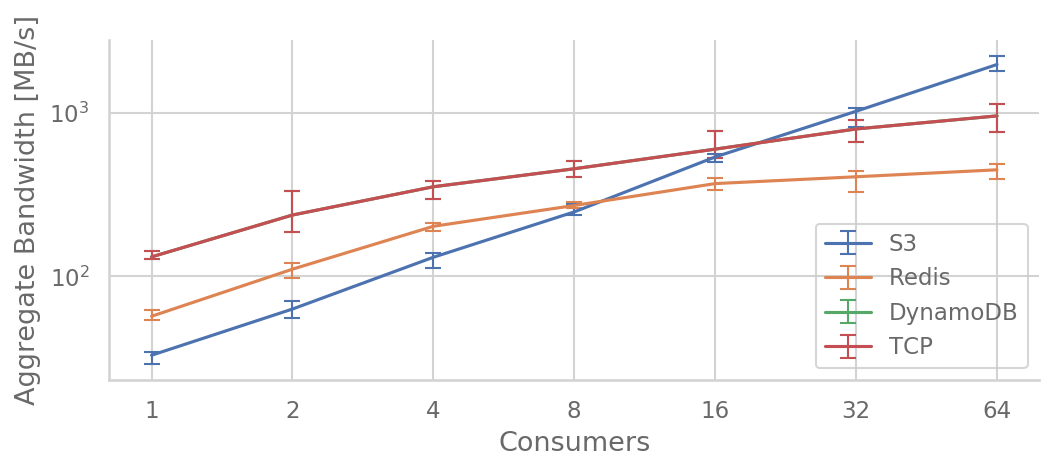

In [62]:
fig, fig2 = plt.figure(figsize=(8,3)), plt.figure(figsize=(8,3))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_scalability_means = {}
one_to_many_scalability_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_scalability_means[experiment_name] = {}
    one_to_many_scalability_cis[experiment_name] = {}
    experiment_base_folder = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out")
    plot_data = {}
    plot_data_bw = {}
    lower_error = []
    upper_error = []
    lower_error_bw = []
    upper_error_bw = []
    num_lambdas = []
    for subf in os.scandir(experiment_base_folder):
        if subf.name != "256" and subf.name != "128":
            num_lambdas.append(int(subf.name))
    for num_lambda in sorted(num_lambdas):    
        var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_lambdas", "out", str(num_lambda))
        res = parse_json(var_base_path)
        deltas = calc_deltas(res)
        run_medians = [np.median(run_data) for run_data in deltas[10000000].values()]
        plot_data[num_lambda] = np.median(run_medians)
        lower_error.append(np.median(run_medians) - np.sort(run_medians)[1])
        upper_error.append(np.sort(run_medians)[-2] - np.median(run_medians))

        values = list(deltas[10000000].values())
        means = [np.mean(run) for run in values]
        one_to_many_scalability_means[experiment_name][num_lambda] = np.mean(means)
        one_to_many_scalability_cis[experiment_name][num_lambda] = scipy.stats.sem(means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(means) - 1)
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += 10 / (latency / 1000)
            #agg_bandwidth /= len(run_arr)
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data_bw[num_lambda] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error_bw.append(lower_ci)
        upper_error_bw.append(upper_ci)

    ax.set_xscale('log')
    ax.set_xlabel("Consumers")
    ax.set_xticks(list(plot_data.keys()))
    ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylabel("Median Communication Time [ms]")
    ax.set_yscale("log")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    ax2.set_xscale('log')
    ax2.set_xlabel("Consumers")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data_bw.keys(), plot_data_bw.values(), [lower_error_bw, upper_error_bw], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_latency.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_scalability_bw.pdf"), bbox_inches='tight')
plt.show()

{0.001: 62.0, 1.0: 65.5, 10.0: 81.0, 100.0: 81.5, 1000.0: 157.5, 10000.0: 323.0, 100000.0: 1930.0}
{0.001: 15.0, 1.0: 23.5, 10.0: 20.5, 100.0: 27.5, 1000.0: 48.0, 10000.0: 298.0, 100000.0: 2630.5}
{0.001: 1.02294921875, 1.0: 1.028076171875, 10.0: 1.0579833984375, 100.0: 13.947021484375, 1000.0: 121.3350830078125, 10000.0: 436.3870849609375, 100000.0: 8400.361572265625}
{0.001: 1.02294921875, 1.0: 1.028076171875, 10.0: 1.0579833984375, 100.0: 13.947021484375, 1000.0: 121.3350830078125, 10000.0: 436.3870849609375, 100000.0: 8400.361572265625}


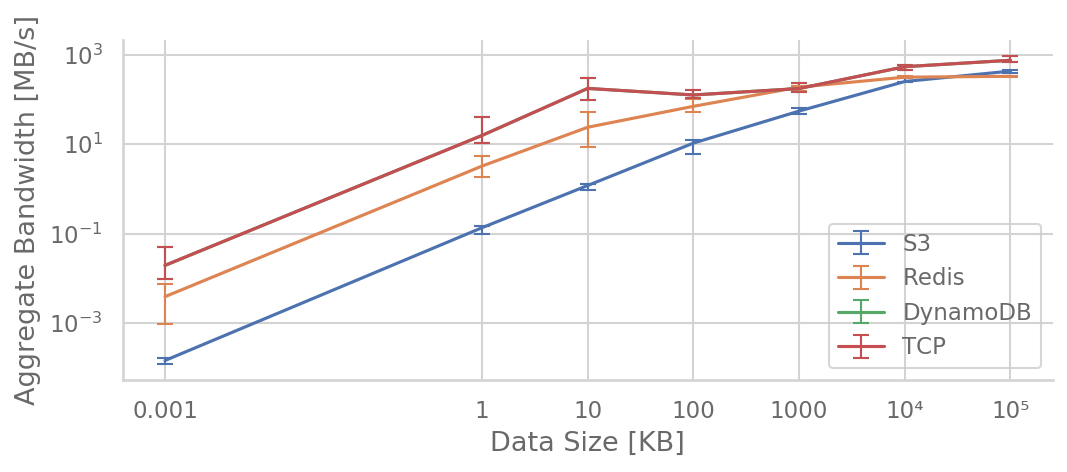

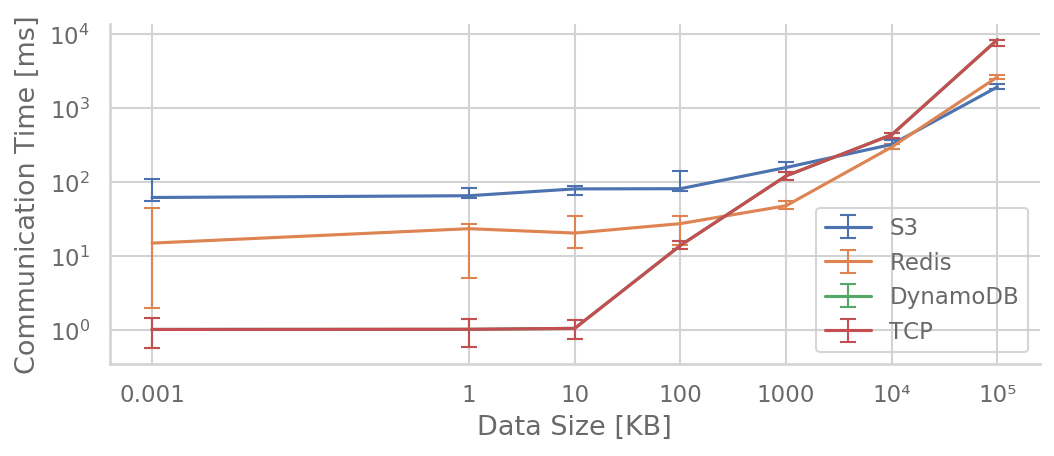

In [63]:
fig, fig2 = plt.figure(figsize=(8,3)), plt.figure(figsize=(8,3))
ax, ax2 = fig.add_subplot(), fig2.add_subplot()
one_to_many_performance_means = {}
one_to_many_performance_cis = {}
for experiment_name, exp_base_path in experiments.items():
    one_to_many_performance_means[experiment_name] = {}
    one_to_many_performance_cis[experiment_name] = {}
    var_base_path = os.path.join(exp_base_path, "one_to_many", "scaling_data", "out")
    res = parse_json(var_base_path)
    deltas = calc_deltas(res)
    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        agg_bandwidths = []
        for run_arr in values:
            agg_bandwidth = 0
            for latency in run_arr:
                if latency == 0:
                    latency = 1
                agg_bandwidth += (file_size / 1000000) / (latency / 1000)
            #agg_bandwidth /= len(run_arr)
            agg_bandwidths.append(agg_bandwidth)
        val = np.median(agg_bandwidths)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(agg_bandwidths)[-2] - val
        lower_ci = val - np.sort(agg_bandwidths)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("Data Size [KB]")
    ax.set_xticks(list(plot_data.keys()))
    ax.set_xticklabels(format_xticks(plot_data.keys()))
    ax.set_ylabel("Aggregate Bandwidth [MB/s]")
    ax.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

    plot_data = {}
    lower_error = []
    upper_error = []
    for file_size in sorted(deltas):
        if file_size == 500000000:
            continue
        values = list(deltas[file_size].values())
        run_means = []
        run_latencies = []
        for run_arr in values:
            run_latencies.append(np.max(run_arr))
            run_means.append(np.mean(run_arr))
        val = np.median(run_latencies)
        one_to_many_performance_means[experiment_name][file_size / 1000] = np.mean(run_means)
        one_to_many_performance_cis[experiment_name][file_size / 1000] = scipy.stats.sem(run_means) * scipy.stats.t.ppf((1 + 0.95) / 2., len(run_means) - 1)
        plot_data[file_size / 1000] = val
        upper_ci = np.sort(run_latencies)[-2] - val
        lower_ci = val - np.sort(run_latencies)[1]
        lower_error.append(lower_ci)
        upper_error.append(upper_ci)
    print(plot_data)
    ax2.set_xscale('log')
    ax2.set_xlabel("Data Size [KB]")
    ax2.set_xticks(list(plot_data.keys()))
    ax2.set_xticklabels(format_xticks(plot_data.keys()))
    ax2.set_ylabel("Communication Time [ms]")
    ax2.set_yscale('log')
    ax2.errorbar(plot_data.keys(), plot_data.values(), [lower_error, upper_error], elinewidth=1, capsize=4, label=experiment_name)

ax.legend()
ax2.legend()
fig.savefig(os.path.join(OUTPUT_PATH, "one-to-many_bandwidth.pdf"), bbox_inches='tight')
fig2.savefig(os.path.join(OUTPUT_PATH, "one-to-many_latency.pdf"), bbox_inches='tight')
plt.show()